# MFCC
 O MFCC faz uso da escala MEL para dividir a banda de frequência em sub-bandas , para posteriormente, extrair os coeficientes cepstrais usando a transformada discreta de cosseno (DCT).  





In [ ]:
# https://drive.google.com/drive/folders/1-EDWQGCG7IlSm-gyV6SBz9YV0HpwefiB?usp=sharing
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import scipy
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from google.colab import files

def normalizevoz(audio,taxamostragem):
    audio = audio / np.max(np.abs(audio))
    return audio

def janelamento(audio, FFTtamanho=2048, espacamento=10, taxamostragem=44100):
    audio = np.pad(audio, int(FFTtamanho / 2), mode='reflect')
    janela_len = np.round(taxamostragem * espacamento / 1000).astype(int)
    janela_num = int((len(audio) - FFTtamanho) / janela_len) + 1
    janelas = np.zeros((janela_num,FFTtamanho))
    for n in range(janela_num):
        janelas[n] = audio[n*janela_len:n*janela_len+FFTtamanho]
    return janelas

def freq_para_mel(freq):
  return 2595.0 * np.log10(1.0 + freq / 700.0)

def parafred(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def pontosdofiltro(fmin, freq_sup, mel_ordem, FFTtamanho, taxamostragem=44100):
  fmin_mel = freq_para_mel(fmin)
  fmax_mel = freq_para_mel(freq_sup)
  mels = np.linspace(fmin_mel, fmax_mel, num=mel_ordem+2)
  freqs = parafred(mels)
  return np.floor((FFTtamanho + 1) / taxamostragem * freqs).astype(int), freqs

def filtros(pontosfiltro, FFT_size):
    filters = np.zeros((len(pontosfiltro)-2,int(FFT_size/2+1)))

    for n in range(len(pontosfiltro)-2):
        filters[n, pontosfiltro[n] : pontosfiltro[n + 1]] = np.linspace(0, 1, pontosfiltro[n + 1] - pontosfiltro[n])
        filters[n, pontosfiltro[n + 1] : pontosfiltro[n + 2]] = np.linspace(1, 0, pontosfiltro[n + 2] - pontosfiltro[n + 1])
    return filters

# def dct(dct_filter_num, filter_len):
#     basis = np.empty((dct_filter_num,filter_len))
#     basis[0, :] = 1.0 / np.sqrt(filter_len)

#     samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

#     for i in range(1, dct_filter_num):
#         basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)

#     return basis

def MFCC(audio,taxamostragem):
  espacamento = 15
  FFTtamanho = 2048

  audio = normalizevoz(audio,taxamostragem)
  audiojanelado = janelamento(audio, FFTtamanho=FFTtamanho, espacamento=espacamento, taxamostragem=taxamostragem)

  window = get_window("hann", FFTtamanho, fftbins=True)
  audio_j = audiojanelado * window

  audio_jTransposto = np.transpose(audio_j)

  audio_fft = np.empty((int(1 + FFTtamanho // 2), audio_jTransposto.shape[1]), dtype=np.complex64, order='F')

  for n in range(audio_fft.shape[1]):
      audio_fft[:, n] = fft.fft(audio_jTransposto[:, n], axis=0)[:audio_fft.shape[0]]

  audio_fft = np.transpose(audio_fft)

  freq_min = 0
  freq_sup = taxamostragem / 2
  mel_ordem= 21

  pontosfiltro, mel_freqs = pontosdofiltro(freq_min, freq_sup, mel_ordem, FFTtamanho, taxamostragem)

  parafred(mel_freqs[-1])

  filters = filtros(pontosfiltro, FFTtamanho)

  enorm = 2.0 / (mel_freqs[2:mel_ordem+2] - mel_freqs[:mel_ordem])
  filters *= enorm[:, np.newaxis]

  potenciaudio = np.square(np.abs(audio_fft))
  audio_filtrado = np.dot(filters, np.transpose(potenciaudio))
  audio_log = 10.0 * np.log10(audio_filtrado)

  dct_filter_num = 21
  # dct_filters = dct(dct_filter_num, 21)
  dct_filters = scipy.fft.dct(dct_filter_num, 21)
  cepstral_coefficents = np.dot(dct_filters, audio_log)
  return cepstral_coefficents.T

In [ ]:
# Building test
from os import listdir
from scipy.io import wavfile
speakers = '/content/drive/MyDrive/UFC/AICT/vox1/vox1_dev_wav/wav'

X = np.zeros((1,21))
Xt = np.zeros((1,21))
y = np.ones((1,1))
yt = np.ones((1,1))

speaker = listdir(speakers)[0]
# for sample in listdir(speakers+'/'+speaker)[0:2]:
#   samplepath = speakers+'/'+speaker+'/'+sample
#   for record in listdir(samplepath)[0:1]:
#     Fs, true_speaker = wavfile.read(samplepath+'/'+record)
#     toX = MFCC(true_speaker,Fs)
#     X = np.concatenate((X,toX))
#     y = np.concatenate((y,np.matrix(toX[:,1]*0+1).T),axis=0)
#     print('true_speaker check '+' '+sample+' '+speaker+' '+str(toX[0,1]*0+1))
#     test = speaker
# X = np.delete(X,0,0)
# y = np.delete(y,0,0)

# for speaker in listdir(speakers)[1:100]:
for speaker in listdir(speakers)[0:100]:
  for sample in listdir(speakers+'/'+speaker)[0:1]:
    samplepath = speakers+'/'+speaker+'/'+sample
    for record in listdir(samplepath)[0:1]:
      Fs, impostor = wavfile.read(samplepath+'/'+record)
      toX = MFCC(impostor,Fs)
      X = np.concatenate((X,toX))
      # y = np.concatenate((y,np.matrix(toX[:,1]*0-1).T),axis=0)
      # print('impostor check '+' '+sample+' '+speaker+' '+str(toX[0,1]*0-1))

# from random import randint
# speaker_test_id = [];
# r_idx = [randint(0, 9) for p in range(0, 20)]
# for speaker in [listdir(speakers)[idx] for idx in r_idx]:
#   for sample in listdir(speakers+'/'+speaker)[0:1]:
#     samplepath = speakers+'/'+speaker+'/'+sample
#     for record in listdir(samplepath)[0:1]:
#       Fs, speaker_test = wavfile.read(samplepath+'/'+record)
#       toX = MFCC(speaker_test,Fs)
#       Xt = np.concatenate((Xt,toX))
#       if speaker==listdir(speakers)[0]:
#         yt = np.concatenate((y,np.matrix(toX[:,1]*0+1).T),axis=0)
#       else:
#         yt = np.concatenate((y,np.matrix(toX[:,1]*0-1).T),axis=0)
#       print('speaker_test check '+' '+sample+' '+speaker)
#       speaker_test_id.append(Xt.shape[0])
# Xt = np.delete(Xt,0,0)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_X = pca.fit_transform(X)
print(pca_X.shape)

(53606, 3)


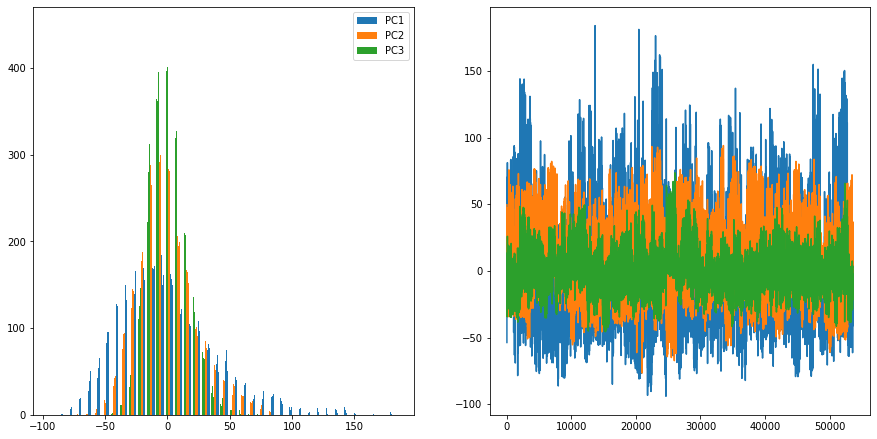

In [ ]:
fig, axs = plt.subplots(1, 2);
axs[0].hist(pca_X,bins=1000);
axs[1].plot(pca_X);
axs[0].legend(('PC1','PC2','PC3'));
fig.set_size_inches(15, 7.5);

From here execute for SVM


In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
scalerX,scalerXt = StandardScaler(),StandardScaler()
scalerX.fit(X)
scalerXt.fit(Xt)
X,Xt = scalerX.transform(X), scalerXt.transform(Xt)

clf = svm.SVC()
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
from scipy import stats
i2 = 0
err = 0
for i1 in range(0,len(speaker_test_id)):
  t = Xt[i2:speaker_test_id[i1]]
  yt_mode = stats.mode(yt[i2:speaker_test_id[i1]]).mode
  y_mode = stats.mode(clf.predict(t)).mode
  if abs(y_mode-yt_mode) > 0:
    err +=1
  print('Moda:',y_mode,'True',yt_mode)
  i2 = speaker_test_id[i1]
print('Error rate:',float(err)/len(speaker_test_id)*100,'%')

Moda: [-1.] True [[1.]]
Moda: [-1.] True [[1.]]
Moda: [-1.] True [[1.]]
Moda: [-1.] True [[1.]]
Moda: [-1.] True [[1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Moda: [-1.] True [[-1.]]
Error rate: 25.0 %


In [ ]:
#yt_label = [np.mean(yt[speaker_test_id[i-1]:speaker_test_id[i]]) for i in range(1,len(speaker_test_id))]